# Task 4 - Causal Effect of Motivational Messages on Student Engagement using the Front Door Criterion
## Outline
### 1. The Front Door Criterion
* Definition and explanation of the fornt door criterion in causal inference
* Relevance to understanding the effects of interventions
### 2. Variables
* Main Variables
* Mediator
* Control Variables
### 3. Conditions for the front door criterion
* Condition 1
* Condtion 2
* Condition 3
### 4. Application example
* Hypothetical, simplified model description (motivational messages on student engagement)
* Measurement of effect of front door criterion of motivational messages on student engagement
### 5. Conclusion
* Summary of importance of the front door criterion in providing reliable causal estimates in educational settings
* Implications for designing interventions to enhance student engagement

## Sources
1. Causal inference challenges and new directions for epidemiologic research on the health effects of social policies - https://link.springer.com/article/10.1007/s40471-022-00288-7
2. On testability of the front-door model via Verma constraints - https://proceedings.mlr.press/v180/bhattacharya22a.html
3. Causal inference in statistics: An overview - https://projecteuclid.org/journals/statistics-surveys/volume-3/issue-none/Causal-inference-in-statistics-An-overview/10.1214/09-SS057.full
4. Robust inference in population indirect causal effects: the generalized front door criterion - https://academic.oup.com/jrsssb/article/82/1/199/7056027
5. A survey on causal inference for recommendation - https://www.cell.com/the-innovation/pdf/S2666-6758(24)00028-6.pdf

## Example
### Scenario
Our goal is to use the front door criterion to measure the causal effect of motivational messages on student engagement. 
### 1. Identify the variables: 
* X (Treatment): Motivational message (0 = not sent , 1 = sent)
* Y (Outcome): Student engagement measured on a continous scale from 0 to 1
* M (Mediator): Perception of message by the student (0 = negative, 1 = positive)
* Z (Control Variable): Initial engagement level of the student measured on acontinous scale from 0 to 1 
### 2. Steps:
#### First stage (Model the effect of X on M, controlling for Z):
* This model estimates the impact of the treatment (sending messages) on the perception of the message, controlling for initial engagement
* M=α+β1×X+β2×Z+ϵ
#### Second stage (Model the effect of M on Y, controlling for X and Z):
* This model estimates the effect of message perception on student engagement, while controlling for both the direct effect of the motivational messages and the initial engagement level. 
* Y=γ+δ1×M+δ2×X+δ3×Z+ν
#### Compute the Controlled Direct Effect (CDE) amd Total Effect (TE):
* Controlled Direct Effect: Direct effect of X on Y controlling for M and Z. Given by the coefficient of X in the second-stage regression
* Total Effect: Overall effect of X on Y mediated through M and controlled by Z. Computed as β1×δ1 from the two models. 
### 3. Adherence to Front Door Criterion
#### The intervention must affect the mediator: 
In our model this means that the treatment X, sending of motivational messages, must influence the mediator, the students perception of the message. We can intuitivly say that this is true and we can model it through the first stage regression. β1 should be significant, indicating that X has a noticable effect on M.
#### There should be no unmeasured confounding between the mediator and the outcome:
In other words we need to measure and control all variables that affect both the mediator and the outcome. In our case the this is variable (Z) the initial engagement. By including Z in both stages, we control for its confounding effect, ensuring the relationship between M and Y is not spurious.
#### The Mediator must affect the outcome, and all paths from the intervention through the mediator to the outcome should be included in the model. 
Our second stage model estimates the effect of the mediator on the outcome while controlling for the direct effect of the treatment and the initial engagement levels. The effect of the mediator on the outcome is represented by δ1, which should be significant if the front door criterion is to hold. 
### 4. Causal Effect Measures
#### Controlled Direct Effect (CDE):
Measures the direct effect of the treatment on the outcome while controlling for both the mediator and any confounders. In our case this helps to understand both the direct and mediated effects. 
#### Total Effect (TE):
Is the combined effect of all paths from the treatment to the outcome, including both direct and mediated paths. This captures the overall impact of the treatment, encompassing all mechanisms through which it works. 


In [61]:
import numpy as np
import pandas as pd
import networkx as nx
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_auc_score

from dowhy import CausalModel

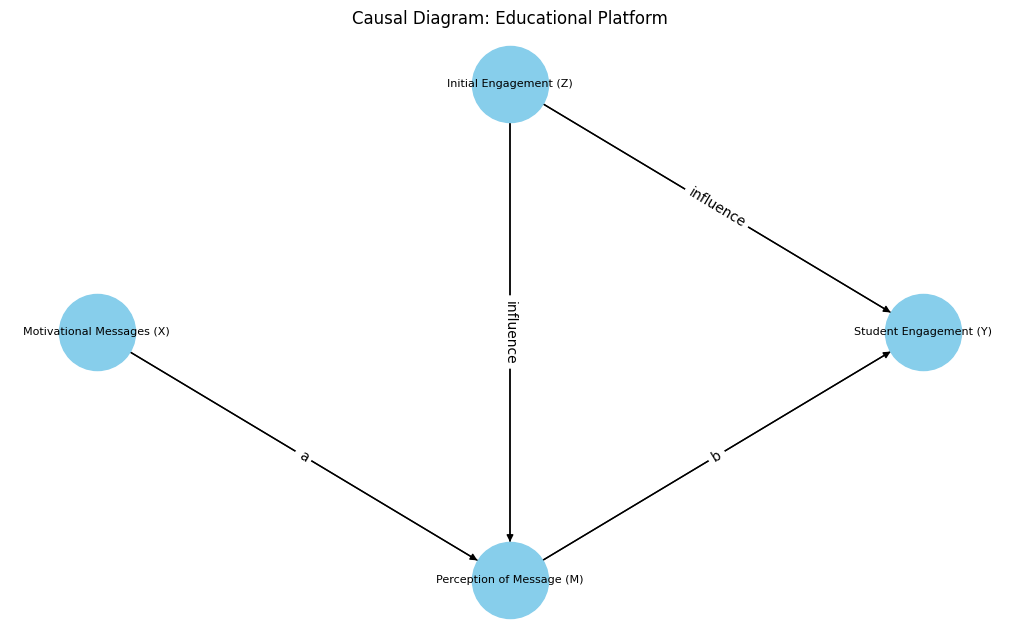

In [62]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes with labels
nodes = {
    'X': 'Motivational Messages (X)',
    'M': 'Perception of Message (M)',
    'Y': 'Student Engagement (Y)',
    'Z': 'Initial Engagement (Z)'
}
G.add_nodes_from(nodes.keys())

# Add edges with labels
edges = [
    ('X', 'M', {'label': 'a'}),
    ('M', 'Y', {'label': 'b'}),
    ('Z', 'M', {'label': 'influence'}),
    ('Z', 'Y', {'label': 'influence'})
]
G.add_edges_from(edges)

# Position nodes using a layout
pos = nx.shell_layout(G)

plt.figure(figsize=(10, 6))

# Draw nodes
nx.draw(G, pos, with_labels=False, node_size=3000, node_color='skyblue', font_size=8, font_weight='bold')

# Draw node labels
for p in pos:  # raise text positions
    pos[p][1] += 0.0
nx.draw_networkx_labels(G, pos, labels=nodes, font_size=8)

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='->', arrowsize=20)

# Draw edge labels
edge_labels = {(n1, n2): d['label'] for n1, n2, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title('Causal Diagram: Educational Platform')
plt.axis('off')  # Turn off the axis
plt.show()  # Display the graph

In [63]:
# Data Generation
np.random.seed(73)
data_size = 1000

# Generate example data
df = pd.DataFrame({
    'X': np.random.binomial(1, 0.5, data_size), # Treatment: motivational messages sent or not
    'Z': np.random.uniform(0, 1, data_size) # Control: initial engagement level
})
df['M'] = np.random.binomial(1, df['X'] * 0.4 + df['Z'] * 0.5) # Mediator: perception of message
df['Y'] = df['Z'] * 0.3 + df['M'] * 0.5 + df['X'] * 0.2 + np.random.normal(0, 0.1, data_size) # Outcome: student engagement

df.head()

,X,Z,M,Y
0,1,0.242081,1,0.816054
1,1,0.406316,1,0.840586
2,1,0.190863,0,0.172163
3,1,0.577323,1,0.950897
4,0,0.843785,1,0.872695


In [64]:
# Model 1: M on X and Z
model_m = sm.Logit(df['M'], sm.add_constant(df[['X', 'Z']])).fit()

# Model 2: Y on M, X and Z
model_y = sm.OLS(df['Y'], sm.add_constant(df[['M', 'X', 'Z']])).fit()

print('Model M on X and Z Coefficients:\n', model_m.params)
print('Model Y on M, X and Z Coefficients:\n', model_y.params)

# Calculate the total effect
total_effect = model_y.params['M'] * model_m.params['X']
print('Estimated total effect of motivational messages on engagement:', total_effect)


Optimization terminated successfully.
         Current function value: 0.572952
         Iterations 5
Model M on X and Z Coefficients:
 const   -2.254633
X        1.753944
Z        2.086378
dtype: float64
Model Y on M, X and Z Coefficients:
 const    0.000250
M        0.494541
X        0.210537
Z        0.301709
dtype: float64
Estimated total effect of motivational messages on engagement: 0.8673964094570442


## Interpretation of Results
### First stage Regression:
* Sending motivational messages significantly increases the likelihood of the messages being preceived positively.We can interpret this as if a message is sent the likelihood is very good of it being perceived positively. 
Constant (const=−2.254633): This value represents the log odds of a positive perception when both X=0 (no message sent) and Z=0 (initial engagement is at its lowest level). A negative constant suggests that in the absence of a message and at the lowest engagement levels, the likelihood of a positive perception (which is conceptually nonexistent in this scenario since no message was sent) is very low.

X Coefficient (1.753944): This coefficient indicates that sending a message significantly increases the log odds of the message being perceived positively. The effect size is quite large, suggesting a strong influence of just sending the message. The interpretation here is a bit conceptual since M technically should only be measured when X=1.

Z Coefficient (2.086378): This positive coefficient suggests that higher initial engagement significantly increases the probability of the message being perceived positively. This could mean that students who are already more engaged are predisposed to view the intervention in a positive light, perhaps due to a more optimistic or receptive attitude towards school-related communications.
### Second stage Regression:
* Positive perception of the message leads to a significant increase in student engagement (+0.495 points)
* The CDE from treatmen on outcome is also substantial with 0.21 points increase. 
* Also the initial engagement has a direct positive impact on the final engagement score

### TE and CDE:
* TE: 0.867 increase on the engagement scale. This indicated that the overall effect of sending motivational messages increases student engagement. 
* CDE: As mentioned above this indicates that just receiving a message has a positive impact on engagement. 

### Front Door Criterions: 
* Condition 1 (Intervention affects the Mediator): Confirmed by significant coefficients in the first stage, indicating that sending messages influences how they are perceived.
* Condition 2 (No Unmeasured Confounding between Mediator and Outcome): Assumed to be satisfied as 
Z (initial engagement), which could be a common cause, is controlled in both stages of the model.
* Condition 3 (Mediator affects the Outcome through all paths): Verified by significant coefficients in the second stage, showing that positive perception of messages increases student engagement.


## Paper Sketch
### 1. The Front Door Criterion
#### Definition and Purpose: 
* Front Door criterion as a method used in causal inference to estimate the causal effcet of an intervention on an outcome through a mediator, even in the precence of unmeasured confounding betwenn the intervention and the outcome
#### Relevance
* Relvance in educational research, particularly in interventions where direcr effects are difficult to measure due to potential confounders
### 2. Variables
#### Scenario
Description of sending messages scenario
#### Main Variables
* Treatment (X)
* Outcome (Y)
#### Mediator
* Perception of Message (M)
#### Control Variables
* Initial Engagement (Z)
### 3. Conditions for the Front Door Criterion
#### Condition 1 Intervention affects the mediator
#### Condition 2 No unmeasured condounding between mediator and outcome
#### Condition 3 Mediator affects the outcome through all paths
### 4. Application Example
#### Hypothetical Model
* Data Generation
* Diagram
#### Measurement of Effect using Front Door criterion
* Model descriptions
* Results
* Interpretation
### 5. Conclusion
#### Summary
#### Implications (in Educational context)